# Text Classification for Support Tickets

This notebook demonstrates text classification using traditional NLP techniques with scikit-learn. We'll implement both Naive Bayes and SVM classifiers to predict ticket types from text content.

## Imports

In [1]:
import sys
import os
import nltk
import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import seaborn as sns

# Add parent directory to path to import local modules
sys.path.append("..")

# Import local modules
from src.models import (
    create_naive_bayes_pipeline, create_svm_pipeline,
    get_grid_search_params, create_grid_search, train_ml_model, predict, create_vectorizer, create_tfidf_transformer
)
from src.evaluate_model import (
    evaluate_model, print_confusion_matrix, print_classification_report,
    plot_confusion_matrix, plot_class_distribution, compare_models
)
from src.utils import save_model, load_model, save_config, load_config, load_dataset_ml

# For Jupyter Notebook
%matplotlib inline
sns.set()

## Set Parameters

In [2]:
train_path = "data/ticket_train.csv"
valid_path = "data/ticket_valid.csv"
test_path = "data/ticket_test.csv"

# Define columns
text_column = "text_cleaned"
label_column = "grouped_queue"

## Prepare Data and Labels

In [3]:
# Load training and testing data from separate files
train_data, train_labels, _ = load_dataset_ml(train_path, text_column, label_column)

test_data, test_labels, unique_labels = load_dataset_ml(test_path, text_column, label_column)

# Print dataset sizes
print(f"Training examples: {len(train_data)}")
print(f"Testing examples: {len(test_data)}")
print(f"Number of classes: {len(unique_labels)}")
print(f"Classes: {unique_labels}")

Loaded data/ticket_train.csv with 27580 rows
Loaded data/ticket_test.csv with 3448 rows
Training examples: 27580
Testing examples: 3448
Number of classes: 3
Classes: ['Customer & Product Support', 'Financial/Other', 'Technical/IT Support']


## Feature Extraction

Feature extraction is essential because it transforms raw text data into numerical representations that machine learning algorithms can understand. The Count Vectorizer converts text into a bag-of-words model, counting the frequency of each word, while the TF-IDF transformer adjusts these frequencies to emphasize more meaningful terms and reduce the influence of common words. 

In [4]:
# Create vectorizer
count_vect = create_vectorizer()

# Create TF-IDF transformer
tfidf_transformer = create_tfidf_transformer()

# Apply to training data
vectorized_data = count_vect.fit_transform(train_data)
print(f"Vectorized data shape: {vectorized_data.shape}")

features = tfidf_transformer.fit_transform(vectorized_data)
print(f"TF-IDF features shape: {features.shape}")

Vectorized data shape: (27580, 10000)
TF-IDF features shape: (27580, 10000)


## Train Naive Bayes Classifier

The following pipeline first vectorizes the text using word frequency (Count Vectorizer) and adjusts the frequencies with TF-IDF to highlight meaningful terms. The Naive Bayes model is then trained on this transformed data to predict class labels, using prior probabilities for improved accuracy.

In [5]:
# Create Naive Bayes pipeline
nb_pipeline = create_naive_bayes_pipeline(
    count_vect,
    tfidf_transformer,
    fit_prior=True
)

# Train the model
print("Training Naive Bayes model...")
nb_pipeline = train_ml_model(nb_pipeline, train_data, train_labels)

Training Naive Bayes model...
Training model...
Training completed in 2.38 seconds


In [6]:
# Evaluate the model
nb_predictions = predict(nb_pipeline, test_data)
nb_accuracy = evaluate_model(nb_predictions, test_labels)

# Print confusion matrix
print_confusion_matrix(test_labels, nb_predictions)

# Print classification report
print_classification_report(test_labels, nb_predictions)

Making predictions...
Model accuracy: 0.6560
Confusion matrix:
[[ 478  211  371]
 [ 218 1115  213]
 [ 158   15  669]]
Classification report:
                            precision    recall  f1-score   support

Customer & Product Support       0.56      0.45      0.50      1060
           Financial/Other       0.83      0.72      0.77      1546
      Technical/IT Support       0.53      0.79      0.64       842

                  accuracy                           0.66      3448
                 macro avg       0.64      0.66      0.64      3448
              weighted avg       0.68      0.66      0.66      3448



'                            precision    recall  f1-score   support\n\nCustomer & Product Support       0.56      0.45      0.50      1060\n           Financial/Other       0.83      0.72      0.77      1546\n      Technical/IT Support       0.53      0.79      0.64       842\n\n                  accuracy                           0.66      3448\n                 macro avg       0.64      0.66      0.64      3448\n              weighted avg       0.68      0.66      0.66      3448\n'

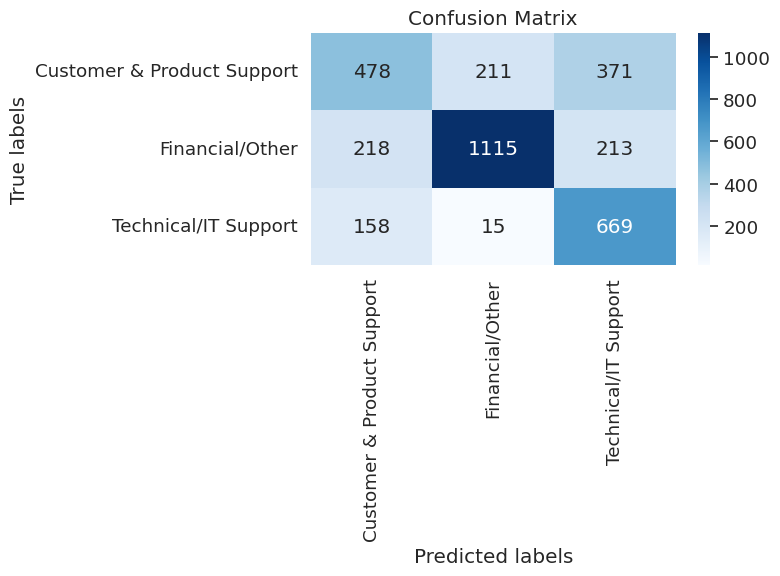

In [7]:
# Plot confusion matrix
plot_confusion_matrix(test_labels, nb_predictions)

The model has an overall accuracy of 66%, meaning it correctly predicted 66% of the instances. The confusion matrix shows misclassifications across all categories, with the "Financial/Other" class performing the best (83% precision, 72% recall). "Customer & Product Support" has lower performance, with 56% precision and 45% recall. The F1-scores show a balance between precision and recall, with "Financial/Other" having the highest score (0.77). The macro average indicates moderate overall performance, while the weighted average (0.66) reflects better results for larger classes.

## Grid Search for Naive Bayes

Grid search is used to systematically evaluate and tune hyperparameters to find the best combination that optimizes the performance of a machine learning model.

Performing grid search for Naive Bayes...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters: {'clf__alpha': 0.001, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}
Making predictions...
Model accuracy: 0.6685
Confusion matrix:
[[ 513  182  365]
 [ 226 1116  204]
 [ 152   14  676]]
Classification report:
                            precision    recall  f1-score   support

Customer & Product Support       0.58      0.48      0.53      1060
           Financial/Other       0.85      0.72      0.78      1546
      Technical/IT Support       0.54      0.80      0.65       842

                  accuracy                           0.67      3448
                 macro avg       0.66      0.67      0.65      3448
              weighted avg       0.69      0.67      0.67      3448



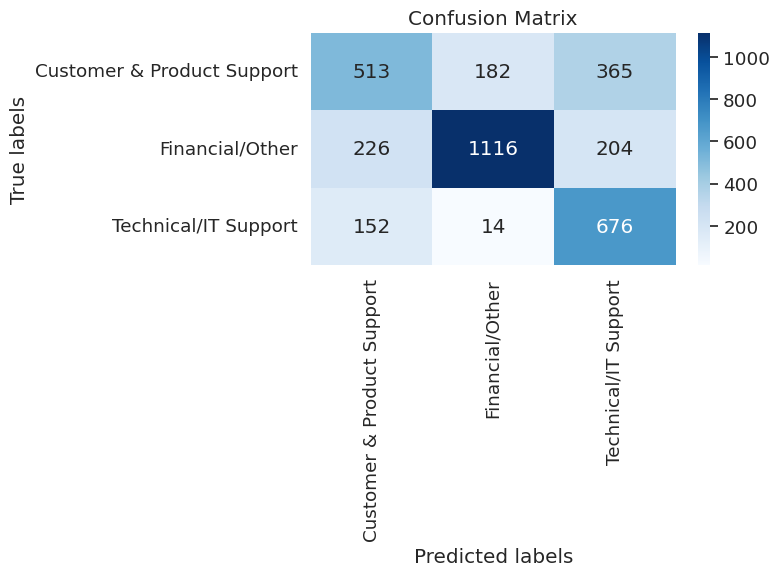

In [11]:
use_grid_search = True

if use_grid_search:
    print("Performing grid search for Naive Bayes...")

    # Get grid search parameters
    nb_params = get_grid_search_params('NB')

    # Create grid search
    nb_gs = create_grid_search(
        nb_pipeline,
        nb_params,
        n_jobs=-1,
        cv=5
    )

    # Train the model with grid search
    nb_gs.fit(train_data, train_labels)
    best_model = nb_gs.best_estimator_

    # Get best parameters
    print(f"Best parameters: {nb_gs.best_params_}")

    # Evaluate the model
    nb_gs_predictions = predict(best_model, test_data)
    nb_gs_accuracy = evaluate_model(nb_gs_predictions, test_labels)

    # Print confusion matrix
    print_confusion_matrix(test_labels, nb_gs_predictions)

    # Print classification report
    print_classification_report(test_labels, nb_gs_predictions)

    # Plot confusion matrix
    plot_confusion_matrix(test_labels, nb_gs_predictions)

Initially, the Naive Bayes model after performing grid search achieved an accuracy of 66.0% with a confusion matrix and classification report indicating challenges in classifying the "Customer & Product Support" class. After tuning with grid search, the model's accuracy increased to 66.85%, with slight improvements across classes, especially in terms of precision for the "Financial/Other" class (85%) and recall for "Technical/IT Support" (80%). The best hyperparameters found were `alpha=0.001`, `use_idf=True` for TF-IDF, and using n-grams (1, 2). This tuning led to a better balance in the model's performance across the three categories.

## Train SVM Classifier

An SVM (Support Vector Machine) pipeline is created using a Count Vectorizer and TF-IDF transformer for text feature extraction, followed by training the model on the provided training data and labels.

In [12]:
# Create SVM pipeline
svm_pipeline = create_svm_pipeline(
    count_vect,
    tfidf_transformer
)

# Train the model
print("Training SVM model...")
svm_pipeline = train_ml_model(svm_pipeline, train_data, train_labels)

Training SVM model...
Training model...
Training completed in 5.66 seconds


In [13]:
# Evaluate the model
svm_predictions = predict(svm_pipeline, test_data)
svm_accuracy = evaluate_model(svm_predictions, test_labels)

# Print confusion matrix
print_confusion_matrix(test_labels, svm_predictions)

# Print classification report
print_classification_report(test_labels, svm_predictions)

Making predictions...
Model accuracy: 0.7007
Confusion matrix:
[[ 659  165  236]
 [ 225 1194  127]
 [ 196   83  563]]
Classification report:
                            precision    recall  f1-score   support

Customer & Product Support       0.61      0.62      0.62      1060
           Financial/Other       0.83      0.77      0.80      1546
      Technical/IT Support       0.61      0.67      0.64       842

                  accuracy                           0.70      3448
                 macro avg       0.68      0.69      0.68      3448
              weighted avg       0.71      0.70      0.70      3448



'                            precision    recall  f1-score   support\n\nCustomer & Product Support       0.61      0.62      0.62      1060\n           Financial/Other       0.83      0.77      0.80      1546\n      Technical/IT Support       0.61      0.67      0.64       842\n\n                  accuracy                           0.70      3448\n                 macro avg       0.68      0.69      0.68      3448\n              weighted avg       0.71      0.70      0.70      3448\n'

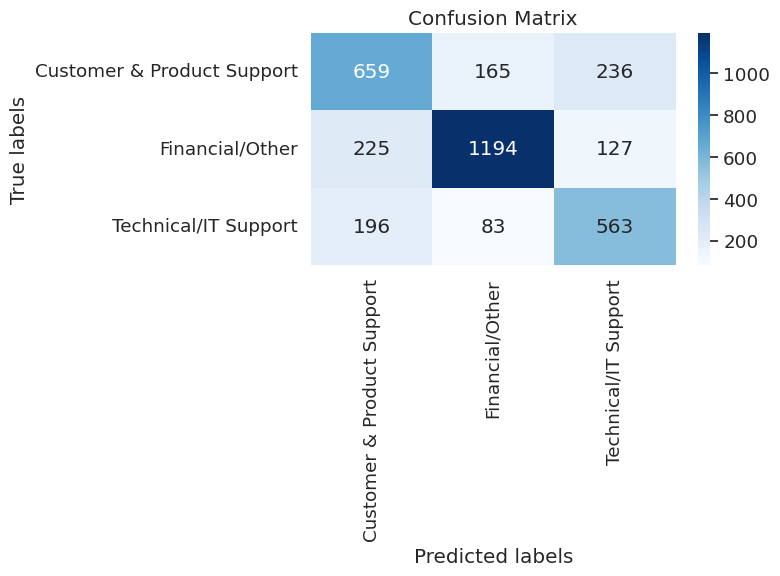

In [14]:
# Plot confusion matrix
plot_confusion_matrix(test_labels, svm_predictions)

The SVM model achieved an accuracy of 70.07%, showing a notable improvement compared to the Naive Bayes model. The "Financial/Other" class had the highest performance, with 83% precision and 77% recall, resulting in an F1-score of 0.80. The "Customer & Product Support" and "Technical/IT Support" classes performed moderately, with F1-scores of 0.62 and 0.64, respectively. The macro average shows balanced performance across all classes, while the weighted average (0.70) reflects the model's overall solid performance, particularly for larger classes like "Financial/Other".

## Grid Search for SVM

Performing grid search for SVM...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'clf__C': 1, 'clf__class_weight': 'balanced', 'tfidf__use_idf': False, 'vect__ngram_range': (1, 2)}
Making predictions...
Model accuracy: 0.7056
Confusion matrix:
[[ 656  122  282]
 [ 241 1147  158]
 [ 177   35  630]]
Classification report:
                            precision    recall  f1-score   support

Customer & Product Support       0.61      0.62      0.61      1060
           Financial/Other       0.88      0.74      0.80      1546
      Technical/IT Support       0.59      0.75      0.66       842

                  accuracy                           0.71      3448
                 macro avg       0.69      0.70      0.69      3448
              weighted avg       0.73      0.71      0.71      3448



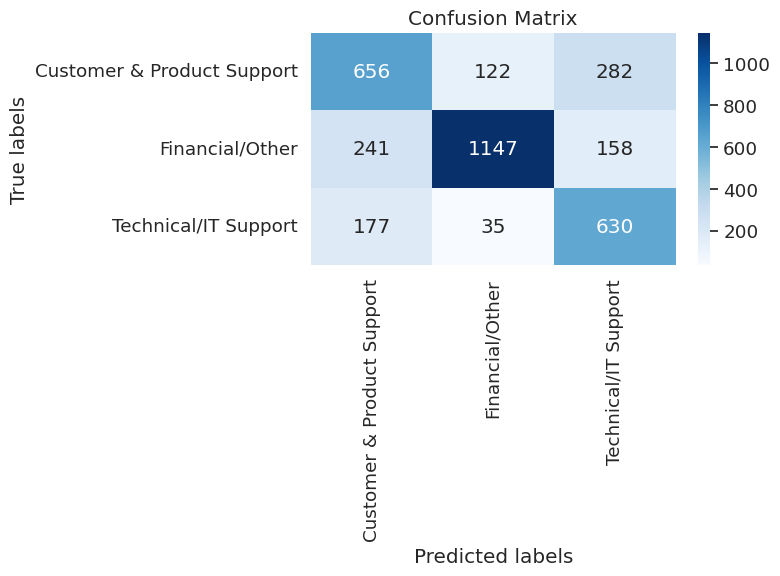

In [15]:
# Set whether to use grid search and other parameters
use_grid_search = True
grid_search_jobs = -1
grid_search_cv = 5

if use_grid_search:
    print("Performing grid search for SVM...")

    # Get grid search parameters
    svm_params = get_grid_search_params('SVM')

    # Create grid search
    svm_gs = create_grid_search(
        svm_pipeline,
        svm_params,
        n_jobs=grid_search_jobs,
        cv=grid_search_cv
    )

    # Train the model with grid search
    svm_gs.fit(train_data, train_labels)
    best_model = svm_gs.best_estimator_

    # Get best parameters
    print(f"Best parameters: {svm_gs.best_params_}")

    # Evaluate the model
    svm_gs_predictions = predict(best_model, test_data)
    svm_gs_accuracy = evaluate_model(svm_gs_predictions, test_labels)

    # Print confusion matrix
    print_confusion_matrix(test_labels, svm_gs_predictions)

    # Print classification report
    print_classification_report(test_labels, svm_gs_predictions)

    # Plot confusion matrix
    plot_confusion_matrix(test_labels, svm_gs_predictions)

The SVM model achieved 70.56% accuracy, with the best performance in "Financial/Other" and "Technical/IT Support," reflecting improved classification across all classes.

## Compare Models

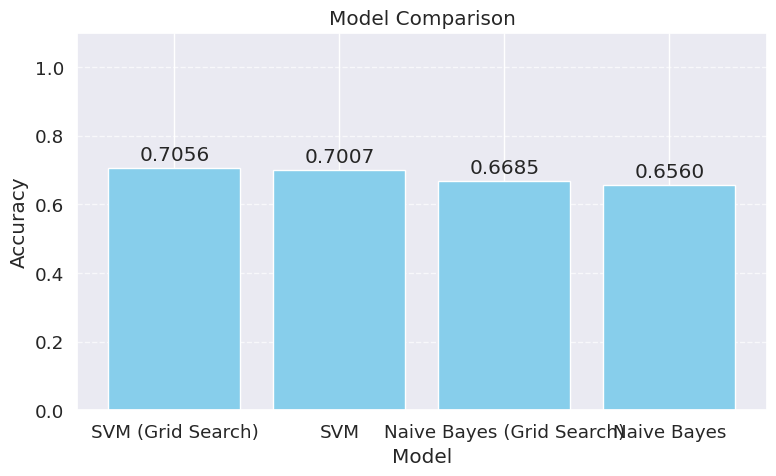

In [16]:
# Set parameters
use_grid_search = True

# Create list of model names and accuracies
model_names = ['Naive Bayes']
accuracies = [nb_accuracy]

if use_grid_search:
    model_names.append('Naive Bayes (Grid Search)')
    accuracies.append(nb_gs_accuracy)

model_names.append('SVM')
accuracies.append(svm_accuracy)

if use_grid_search:
    model_names.append('SVM (Grid Search)')
    accuracies.append(svm_gs_accuracy)

# Compare models
compare_models(model_names, accuracies)

## Save the Best Model

In [17]:
# Set direct parameters
save_model_flag = True
model_dir = "models"
model_name = "best_ml_model.pkl"

if save_model_flag:
    # Determine the best model based on accuracy
    best_model_idx = np.argmax(accuracies)
    best_model_name = model_names[best_model_idx]
    print(f"Best model: {best_model_name} with accuracy {accuracies[best_model_idx]:.4f}")

    # Get the best model
    if best_model_name == 'Naive Bayes':
        best_model = nb_pipeline
    elif best_model_name == 'Naive Bayes (Grid Search)':
        best_model = nb_gs.best_estimator_  # Using best_estimator_ for grid search models
    elif best_model_name == 'SVM':
        best_model = svm_pipeline
    elif best_model_name == 'SVM (Grid Search)':
        best_model = svm_gs.best_estimator_  # Using best_estimator_ for grid search models

    # Save the model
    model_path = os.path.join(model_dir, model_name)
    # Create directory if it doesn't exist
    os.makedirs(model_dir, exist_ok=True)
    save_model(best_model, model_path)
    print(f"Model saved to {model_path}")

Best model: SVM (Grid Search) with accuracy 0.7056
Model saved to models/best_ml_model.pkl
Model saved to models/best_ml_model.pkl
